# Surface relative humidity calculation

## 1 Overview

- Notebook intended to calculate relative humidity at surface based on ERA-INTERIM datasets of temperature and dew point temperature both at surface (2 m above the ground).

- **References**:

    - [ERA datasets: near-surface humidity](https://confluence.ecmwf.int/display/CKB/ERA+datasets%3A+near-surface+humidity).

    - [Calculate Temperature, Dewpoint, or Relative Humidity](http://andrew.rsmas.miami.edu/bmcnoldy/Humidity.html).

- Based on Clausius-Clayperon equation:

    $$ 
    e_s(T) = 6.1094 \exp{\left( \frac{17.625 T}{T + 243.04} \right)}
    $$
    where $T$ is temperature in degree Celsius, you can calculate relative humidity $RH$ as the following:

    $$
    RH = \frac{e_s(T_d)}{e_s(T)} 100 \%
    $$
    where $T_d$ is the dew point temperature.

**Comments:**

 - The package cfgrib creates index files which makes reading much faster.

## 2 Initial setup

In [1]:
# Load packages.
import sys
import importlib
import glob
import calendar
import datetime
import progressbar
import os

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs

# Figures inside this notebook.
%matplotlib inline

In [2]:
# My repository.
repository = "/home/alex/Dropbox/repositories/doctoral_thesis/libraries/"

In [3]:
# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my libraries.
import cdlearn

**===============================================================================================**

In [4]:
# Incorporate ongoing changes.
importlib.reload(cdlearn);

**===============================================================================================**

In [5]:
# Folder with ERA-INTERIM data.
data_folder = "/media/alex/ALEXDATA/data_sets/ERA_INTERIM/"

## 3 Read surface temperature

In [6]:
# Data folder.
sfct_folder = data_folder + "surface_temperature_daily/"

# Absolute files paths. Only grib extensions.
sfct_files_paths = sorted(glob.glob(sfct_folder + "*grb"))

print("Number of files:", len(sfct_files_paths))

Number of files: 480


In [7]:
#%%time

# Read data using xarray package.
SFCT = xr.open_mfdataset(sfct_files_paths, engine="cfgrib")

# Guarantee time ordering.
SFCT = SFCT.sortby("time")

In [8]:
SFCT

<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 58440)
Coordinates:
    number      int64 0
    step        timedelta64[ns] 00:00:00
    surface     int64 0
  * latitude    (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
  * time        (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
    valid_time  (time) datetime64[ns] dask.array<shape=(58440,), chunksize=(124,)>
Data variables:
    t2m         (time, latitude, longitude) float32 dask.array<shape=(58440, 241, 480), chunksize=(124, 241, 480)>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2019-06-15T23:46:46 GRIB to CDM+CF via cfgri

## 4 Read surface dew point temperature

In [9]:
# Data folder.
sfcdpt_folder = data_folder + "surface_dew_point_temperature_daily/"

# Absolute files paths. Only grib extensions.
sfcdpt_files_paths = sorted(glob.glob(sfcdpt_folder + "*grb"))

print("Number of files:", len(sfcdpt_files_paths))

Number of files: 480


In [10]:
# %%time

# Read data using xarray package.
SFCDPT = xr.open_mfdataset(sfcdpt_files_paths, engine="cfgrib")

# Guarantee time ordering.
SFCDPT = SFCDPT.sortby("time")

In [11]:
SFCDPT

<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 58438)
Coordinates:
    number      int64 0
    step        timedelta64[ns] 00:00:00
    surface     int64 0
  * latitude    (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
  * time        (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
    valid_time  (time) datetime64[ns] dask.array<shape=(58438,), chunksize=(124,)>
Data variables:
    d2m         (time, latitude, longitude) float32 dask.array<shape=(58438, 241, 480), chunksize=(124, 241, 480)>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2019-06-15T23:47:26 GRIB to CDM+CF via cfgri

## 5 Calculating relative humidity

In [12]:
def relative_humidity_retrieval(T, TD):
    """
    Relative humidity calculation.
    
    The inputs are xarray DataArrays for surface temperature (T) and for
    surface dew point temperature (TD). This function uses Clausius-Clayperon
    equation in the following form:
    
    es(T) = 6.1094 * exp((17.625 * T) / (T + 243.04))
    
    for calculating surface relative humidity as:
    
    RH = es(Td) / es(T) * 100%
    
    The output is also a xarray DataArray class.
    """
    
    # Put the in the same spatio-temporal grid.
    T, TD = xr.align(T, TD)
    
    es_T = 6.1094 * np.exp((17.625 * T) / (T + 243.04))
    es_Td = 6.1094 * np.exp((17.625 * TD) / (TD + 243.04))
    
    return es_Td / es_T * 100

In [13]:
# Surface relative humidity in percentage (as xarray DataArray class).
RELHUM = relative_humidity_retrieval(SFCT.t2m, SFCDPT.d2m)

In [14]:
# Let's convert from DataArray to Dataset xarray object.
RELHUM = RELHUM.to_dataset(name="relhum")

In [15]:
# Add some attributes.
RELHUM.attrs["Calculation"] = "Made by Alex Araujo at " + \
                               datetime.datetime.now().strftime("%Y-%m-%d")
RELHUM.attrs["Origin"] = "ERA-INTERIM data sets for surface temperature and " + \
                         "surface dew point temperatures (at 2 m above the ground)"
RELHUM.relhum.attrs["units"] = "%"

In [16]:
RELHUM

<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 58438)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
    number      int64 0
    step        timedelta64[ns] 00:00:00
    surface     int64 0
  * latitude    (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
    valid_time  (time) datetime64[ns] dask.array<shape=(58438,), chunksize=(124,)>
Data variables:
    relhum      (time, latitude, longitude) float32 dask.array<shape=(58438, 241, 480), chunksize=(124, 241, 480)>
Attributes:
    Calculation:  Made by Alex Araujo at 2019-06-15
    Origin:       ERA-INTERIM data sets for surface temperature and surface d...

## 6 Exporting relative humidity data as netcdf files

**This is done just once.**

In [17]:
# Pandas date times.
dates = pd.to_datetime(RELHUM.time.values)

# Range of dates. 
years = dates.year.unique()
months = dates.month.unique()
number_of_iterations = years.size * months.size

# Where data will be put.
data_path = "/media/alex/ALEXDATA/data_sets/ERA_INTERIM/surface_relative_humidity_daily/"

# Root for file name.
root = "relhum_daily_"

# Loop over each month in each year.
with progressbar.ProgressBar(max_value=number_of_iterations) as p:
    index = 0
    for year in years:
        for month in months:
    
            # Data file.
            file_path = data_path + root + "{0:04d}_{1:02d}.nc".format(year, month)
    
            # Continue only if data file does not exist yet.
            if not os.path.isfile(file_path):
    
                # Select data corresponding to this date.
                DATASET = RELHUM.sel(time=str(year) + "-" + str(month))
            
                # Export selected data as a netcdf file.
                DATASET.to_netcdf(file_path)
            
            index += 1
            p.update(index)

100% (480 of 480) |######################| Elapsed Time: 0:23:30 Time:  0:23:30


## 7 Read surface relative humidity

In [18]:
# Data folder.
sfcrh_folder = data_folder + "surface_relative_humidity_daily/"

# Absolute files paths. Only netcdf extensions.
sfcrh_files_paths = sorted(glob.glob(sfcrh_folder + "*nc"))

print("Number of files:", len(sfcrh_files_paths))

Number of files: 480


In [19]:
# %%time

# Read data as xarray Dataset class.
RELHUM = xr.open_mfdataset(sfcrh_files_paths)

In [20]:
RELHUM

<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 58438)
Coordinates:
    number      int64 0
    step        timedelta64[ns] 00:00:00
    surface     int64 0
  * latitude    (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
  * time        (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
    valid_time  (time) datetime64[ns] dask.array<shape=(58438,), chunksize=(124,)>
Data variables:
    relhum      (time, latitude, longitude) float32 dask.array<shape=(58438, 241, 480), chunksize=(124, 241, 480)>
Attributes:
    Calculation:  Made by Alex Araujo at 2019-06-15
    Origin:       ERA-INTERIM data sets for surface temperature and surface d...

## 8 Monthly means of surface relative humidity

In [21]:
# Group data by month and then calculate the mean.
RELHUM_mm = RELHUM.relhum.groupby("time.month").mean("time")

In [22]:
RELHUM_mm

<xarray.DataArray 'relhum' (month: 12, latitude: 241, longitude: 480)>
dask.array<shape=(12, 241, 480), dtype=float32, chunksize=(1, 241, 480)>
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
    surface    int64 0
  * latitude   (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude  (longitude) float64 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

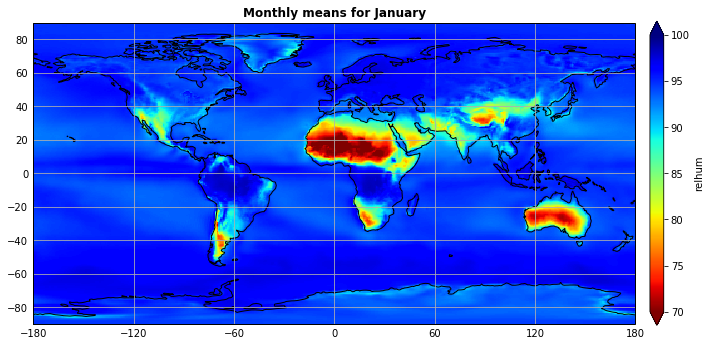

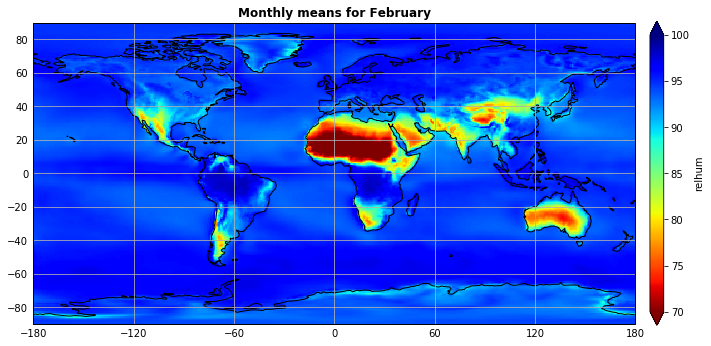

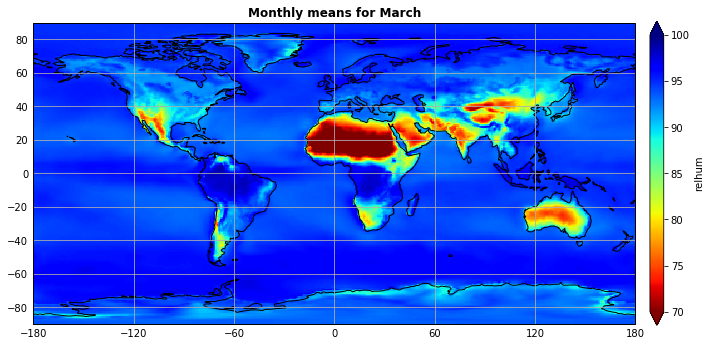

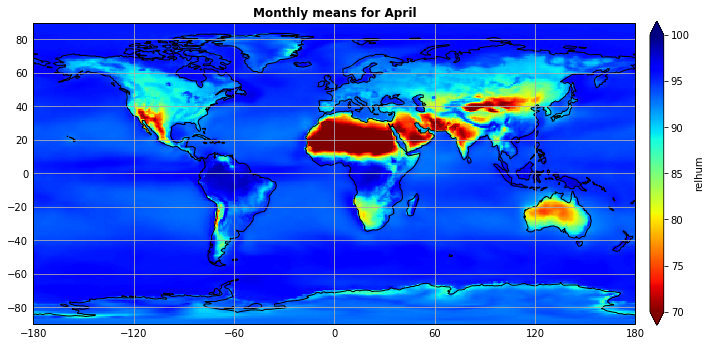

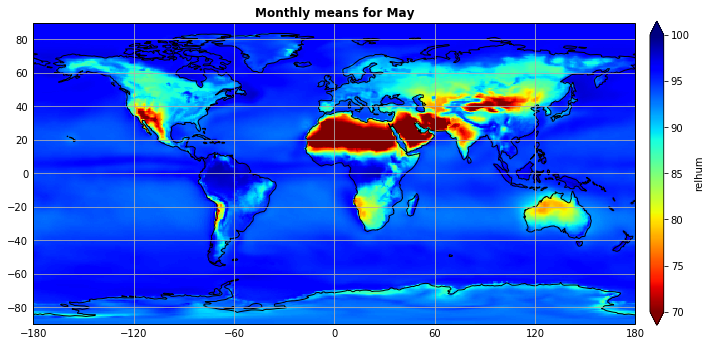

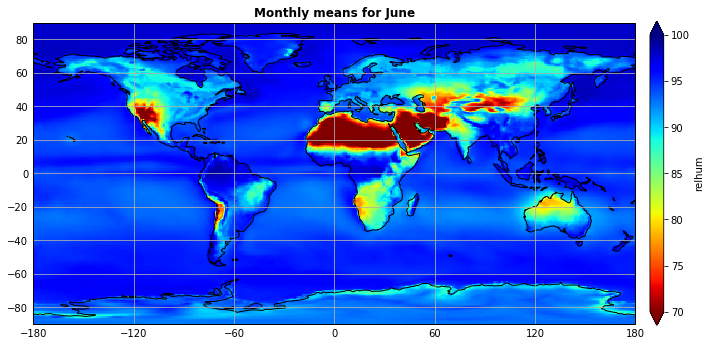

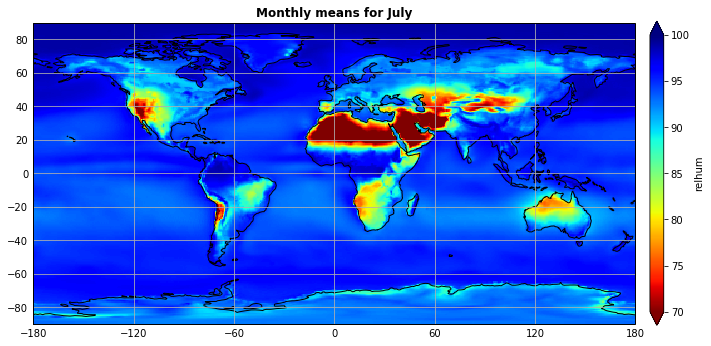

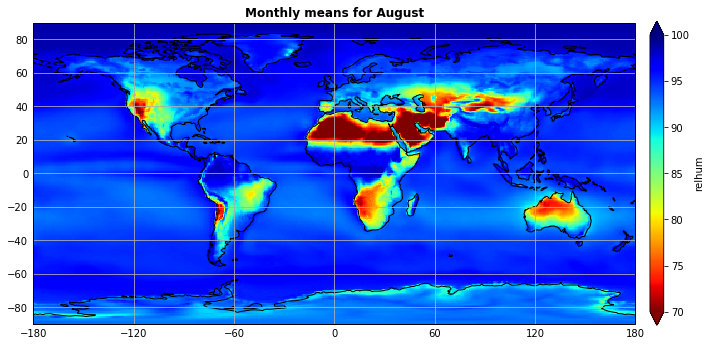

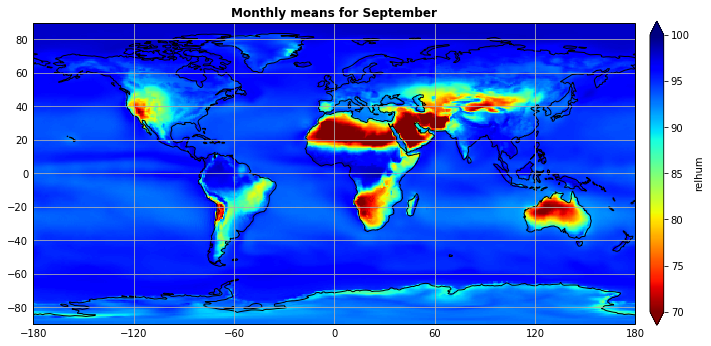

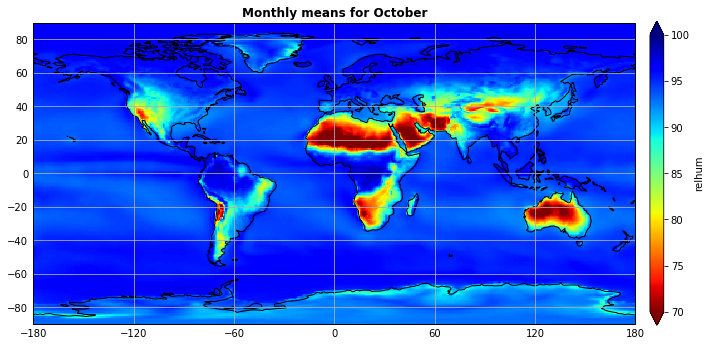

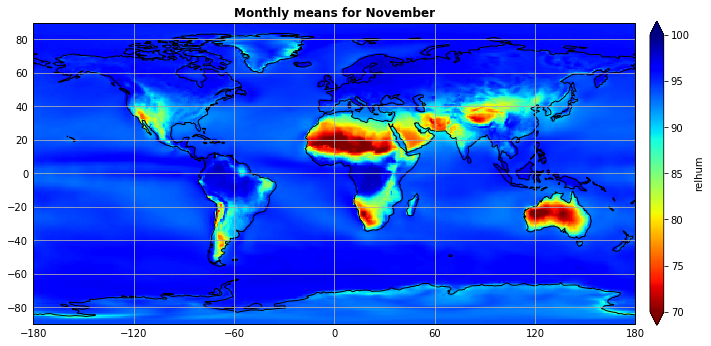

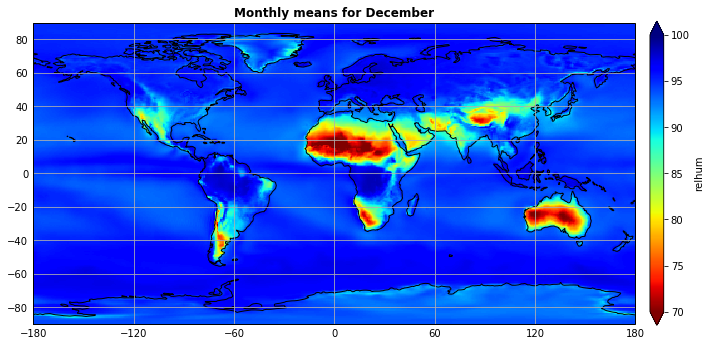

In [23]:
# Plot monthly means.
for month in range(1, 13):
    
    # Make map.
    fig = plt.figure(figsize=(13, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    map = RELHUM_mm.sel(month=month).plot(ax=ax, 
                                          vmin=70, vmax=100,
                                          cmap=plt.cm.jet_r, 
                                          cbar_kwargs={"shrink": 0.80,
                                                       "pad": 0.020,
                                                       "extend": "both"})
    ax.set_title("Monthly means for " + calendar.month_name[month], weight="bold");

## 9 Time series

In [24]:
# Select a pixel around Amazonia.
lon = 120; lat = -5

In [25]:
# %%time

# Retrieve 6-hourly time series as pandas Series.
RELHUM_ts = RELHUM.relhum.sel(longitude=lon, latitude=lat, method="nearest")

# Retrieve daily time series.
RELHUM_ts_dm = RELHUM_ts.resample({"time": "1D"}).mean("time")

# Retrieve monthly time series.
RELHUM_ts_mm = RELHUM_ts.resample({"time": "1MS"}).mean("time")

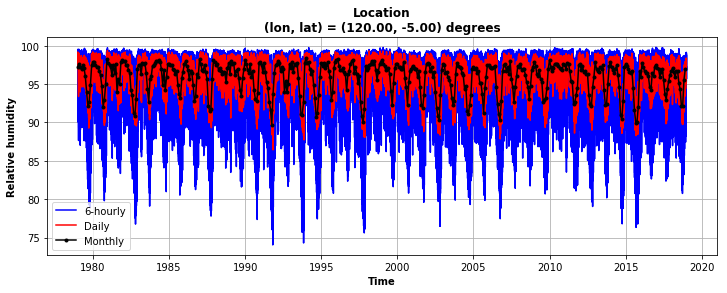

In [28]:
# Plot these time series.
plt.figure(figsize=(12, 4))
plt.plot(RELHUM_ts.time, RELHUM_ts.values, "-b", label="6-hourly")
plt.plot(RELHUM_ts_dm.time, RELHUM_ts_dm.values, "-r", label="Daily")
plt.plot(RELHUM_ts_mm.time, RELHUM_ts_mm.values, ".-k", label="Monthly")
plt.xlabel("Time", weight="bold")
plt.ylabel("Relative humidity", weight="bold")
plt.title("Location\n(lon, lat) = (%.2f, %.2f) degrees" %(lon, lat), weight="bold")
plt.grid()
plt.legend();

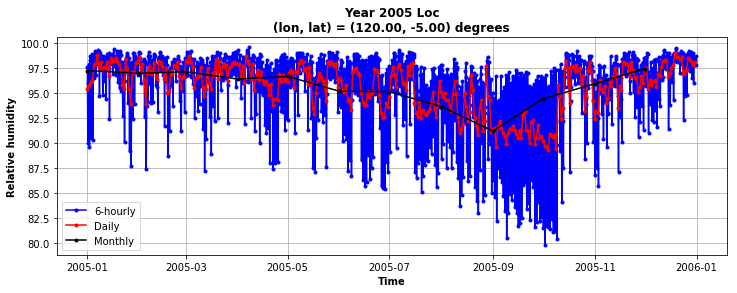

In [41]:
# The same as before, but just for one year.
year = "2005"
plt.figure(figsize=(12, 4))
plt.plot(RELHUM_ts.sel(time=year).time, RELHUM_ts.sel(time=year).values, 
         ".-b", label="6-hourly")
plt.plot(RELHUM_ts_dm.sel(time=year).time, RELHUM_ts_dm.sel(time=year).values, 
         ".-r", label="Daily")
plt.plot(RELHUM_ts_mm.sel(time=year).time, RELHUM_ts_mm.sel(time=year).values, 
         ".-k", label="Monthly")
plt.xlabel("Time", weight="bold")
plt.ylabel("Relative humidity", weight="bold")
plt.title("Year %s Loc\n(lon, lat) = (%.2f, %.2f) degrees" %(year, lon, lat), weight="bold")
plt.grid()
plt.legend();